In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Labels 
labels_map = {  0: "T-shirt/top",
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle boot" }

In [3]:
data_train = "../fashionmnist/fashion-mnist_train.csv"

In [4]:
df = pd.read_csv(data_train)

In [5]:
df.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def get_random_sample_data(dataframe, number):
    return dataframe.sample(number)

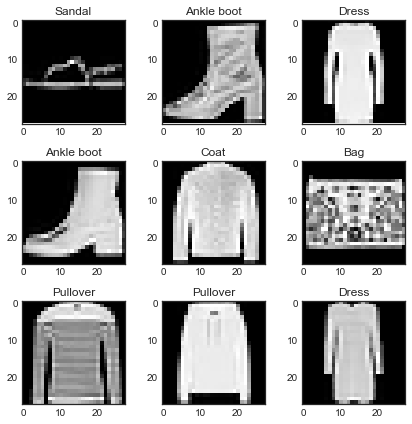

In [8]:
# Randomly select 9 data from dataframe
num = 9
df_samp = get_random_sample_data(df, num)
plt.figure(figsize=(6, 6))
for i in range(num):
    example = df_samp.iloc[[i], 1:].values.reshape(28,28)
    target = df_samp["label"].values[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(example, cmap='gray')
    plt.title(str(labels_map[target]))
plt.tight_layout()

In [49]:
# df_samp.iloc[[1], 1:].values.reshape(-1)  # reshaping into 784, vectors 

In [54]:
def get_data(dataframe):
    data = []
    label = []
    for idx, row in dataframe.iterrows():
        data.append(row.values[1:].reshape(-1))
        label.append(row.values[:1].reshape(-1))
    return data, label

In [55]:
x, y = get_data(df)

In [74]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.33, random_state=42)

In [9]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [10]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [11]:
encoder = Model(input_img, encoded)


In [12]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [13]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [75]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print( x_test.shape)

(40200, 784)
(19800, 784)


In [76]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 40200 samples, validate on 19800 samples
Epoch 1/50
40200/40200 [==============================] - 3s 75us/step - loss: 0.4470 - val_loss: 0.3795
Epoch 2/50
40200/40200 [==============================] - 3s 76us/step - loss: 0.3608 - val_loss: 0.3537
Epoch 3/50
40200/40200 [==============================] - 3s 70us/step - loss: 0.3440 - val_loss: 0.3415
Epoch 4/50
40200/40200 [==============================] - 3s 77us/step - loss: 0.3354 - val_loss: 0.3342
Epoch 5/50
40200/40200 [==============================] - 3s 74us/step - loss: 0.3297 - val_loss: 0.3300
Epoch 6/50
40200/40200 [==============================] - 3s 72us/step - loss: 0.3253 - val_loss: 0.3267
Epoch 7/50
40200/40200 [==============================] - 4s 97us/step - loss: 0.3216 - val_loss: 0.3223
Epoch 8/50
40200/40200 [==============================] - 4s 96us/step - loss: 0.3185 - val_loss: 0.3200
Epoch 9/50
40200/40200 [==============================] - 3s 82us/step - loss: 0.3159 - val_loss: 0.3178
Epoch

In [77]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

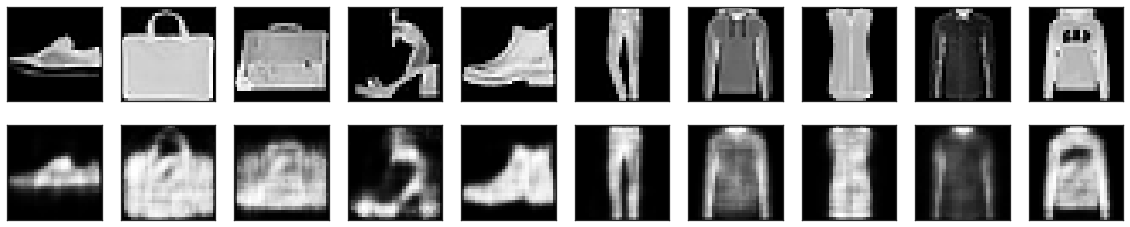

In [78]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()